In [ ]:
#loading the necessary libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from xgboost import XGBClassifier
from keras import regularizers
from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Flatten, Dense, Dropout,SpatialDropout1D, Activation
from keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
#using the dataset with 15 observations I set aside in Part 2 to compare the performance of all of the models I created
#against Vader and my own sentiment analysis
sent_vader=pd.read_excel('vader.xlsx')
sent_vader.head()

,Unnamed: 0,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,0,gp:AOqpTOEVAaqxNXyjz1hB3k7bEho_AxkJ7SrFwRwyyis...,I liike it,pos,0,25.9,2021/03/16,NaN,NaN
1,1,gp:AOqpTOFFp_buXI33ICX36w-olVNV5lFmecsHLkRzonr...,Good,pos,0,26.2.2,2021/03/16,NaN,NaN
2,2,gp:AOqpTOF8LXTtGD_LP6mw6LtOa3_sPBZA_9X5bDBpON2...,Wonder selection of music from all around the ...,pos,0,26.2.2,2021/03/16,NaN,NaN
3,3,gp:AOqpTOFsr7yM-5jNNc-SfkPgyA1SN-ErGk41mCpH3mD...,"I'm using TuneIn Radio since 2011 until now,th...",pos,0,26.2.2,2021/03/16,NaN,NaN
4,4,gp:AOqpTOH3n9ClNv33CGS_H2b9TEzNRkUKLI3EHsV6Z00...,App is Good but Reason Why is The Amazon App h...,neg,0,NaN,2021/03/16,NaN,NaN


In [15]:
sent_vader.shape

(15, 9)

In [16]:
#using Vader sentiment analyzer to get the dominant sentiment for each of the observation
analyzer = SentimentIntensityAnalyzer()
sent_vader['compound'] = [analyzer.polarity_scores(v)['compound'] for v in sent_vader['content']]

In [17]:
sent_vader

,Unnamed: 0,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,compound
0,0,gp:AOqpTOEVAaqxNXyjz1hB3k7bEho_AxkJ7SrFwRwyyis...,I liike it,pos,0,25.9,2021/03/16,NaN,NaN,0.0000
1,1,gp:AOqpTOFFp_buXI33ICX36w-olVNV5lFmecsHLkRzonr...,Good,pos,0,26.2.2,2021/03/16,NaN,NaN,0.4404
2,2,gp:AOqpTOF8LXTtGD_LP6mw6LtOa3_sPBZA_9X5bDBpON2...,Wonder selection of music from all around the ...,pos,0,26.2.2,2021/03/16,NaN,NaN,0.6249
3,3,gp:AOqpTOFsr7yM-5jNNc-SfkPgyA1SN-ErGk41mCpH3mD...,"I'm using TuneIn Radio since 2011 until now,th...",pos,0,26.2.2,2021/03/16,NaN,NaN,0.0000
4,4,gp:AOqpTOH3n9ClNv33CGS_H2b9TEzNRkUKLI3EHsV6Z00...,App is Good but Reason Why is The Amazon App h...,neg,0,NaN,2021/03/16,NaN,NaN,0.4588
5,5,gp:AOqpTOEUe27aJj8sNGxHIJZ3x_IxvQvW9qbsGH-4QuM...,Good,pos,0,26.2.2,2021/03/16,NaN,NaN,0.4404
6,8,gp:AOqpTOHCknZY3z0h1LzbqNOJUw09folVEE9Uncaiu-d...,Does not work with some of my favorite stations,neg,0,NaN,2021/03/16,NaN,NaN,0.4588
7,14,gp:AOqpTOETATayONoers4A5s6hKIfAYlPlC7ymz-twNPR...,"DO NOT INSTALL, Sold my info, I get daily call...",neg,0,25.9,2021/03/15,Thanks for writing to us. We do not sell users...,2021/03/15,0.2023
8,16,gp:AOqpTOGey7pRRVoMnpemXVbJ0GpZ1v1DraKtyEt-dTB...,Trying,neg,0,NaN,2021/03/15,Thanks for writing to us. If you need assistan...,2021/03/15,0.0000
9,28,gp:AOqpTOH5vKNQ-AQiZ0v8Ta-xVap_bjlT3VIio3DMRkR...,Nice lots of options. Buffers a lot regardless...,neu,0,26.2.2,2021/03/15,Thank you for writing to us. That shouldn't be...,2021/03/15,0.7269


In [18]:
#mapping the results to "neu","neg", and "pos"
sent_vader['compound_txt'] = sent_vader['compound'].apply(lambda x : 'pos' if x >= 0.05 else ('neg' if x <= - 0.05 else 'neu'))

In [19]:
sent_vader

,Unnamed: 0,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,compound,compound_txt
0,0,gp:AOqpTOEVAaqxNXyjz1hB3k7bEho_AxkJ7SrFwRwyyis...,I liike it,pos,0,25.9,2021/03/16,NaN,NaN,0.0000,neu
1,1,gp:AOqpTOFFp_buXI33ICX36w-olVNV5lFmecsHLkRzonr...,Good,pos,0,26.2.2,2021/03/16,NaN,NaN,0.4404,pos
2,2,gp:AOqpTOF8LXTtGD_LP6mw6LtOa3_sPBZA_9X5bDBpON2...,Wonder selection of music from all around the ...,pos,0,26.2.2,2021/03/16,NaN,NaN,0.6249,pos
3,3,gp:AOqpTOFsr7yM-5jNNc-SfkPgyA1SN-ErGk41mCpH3mD...,"I'm using TuneIn Radio since 2011 until now,th...",pos,0,26.2.2,2021/03/16,NaN,NaN,0.0000,neu
4,4,gp:AOqpTOH3n9ClNv33CGS_H2b9TEzNRkUKLI3EHsV6Z00...,App is Good but Reason Why is The Amazon App h...,neg,0,NaN,2021/03/16,NaN,NaN,0.4588,pos
5,5,gp:AOqpTOEUe27aJj8sNGxHIJZ3x_IxvQvW9qbsGH-4QuM...,Good,pos,0,26.2.2,2021/03/16,NaN,NaN,0.4404,pos
6,8,gp:AOqpTOHCknZY3z0h1LzbqNOJUw09folVEE9Uncaiu-d...,Does not work with some of my favorite stations,neg,0,NaN,2021/03/16,NaN,NaN,0.4588,pos
7,14,gp:AOqpTOETATayONoers4A5s6hKIfAYlPlC7ymz-twNPR...,"DO NOT INSTALL, Sold my info, I get daily call...",neg,0,25.9,2021/03/15,Thanks for writing to us. We do not sell users...,2021/03/15,0.2023,pos
8,16,gp:AOqpTOGey7pRRVoMnpemXVbJ0GpZ1v1DraKtyEt-dTB...,Trying,neg,0,NaN,2021/03/15,Thanks for writing to us. If you need assistan...,2021/03/15,0.0000,neu
9,28,gp:AOqpTOH5vKNQ-AQiZ0v8Ta-xVap_bjlT3VIio3DMRkR...,Nice lots of options. Buffers a lot regardless...,neu,0,26.2.2,2021/03/15,Thank you for writing to us. That shouldn't be...,2021/03/15,0.7269,pos


In [3]:
#loading the undersampled sample created in Part 2 to create and validate the models
df_smaller=pd.read_excel('downsampled_clean_func.xlsx')

In [5]:
df_smaller['clean_text'] = df_smaller['clean_text'].astype(str)
df_smaller['score'] = df_smaller['score'].astype(str)

In [21]:
#using the same function as before to cross-validate the model and a function to test the model on the set aside 15 observations 
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression()

def lr_cv(splits, X, Y, pipeline, average_method, testing):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        model_sentiment=lr_fit.predict(testing)
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('              negative    neutral     positive')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
 
    return(model_sentiment)

In [22]:
#running the same logistic regression model to be able to compare all of the models
from sklearn.pipeline import Pipeline
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])

In [23]:
#results of logistic regression and the output for the 15 observations I set aside to test
lr_cv(5, df_smaller.clean_text, df_smaller.score, original_pipeline, 'macro', sent_vader.content)


              negative    neutral     positive
precision: [0.69506941 0.6059584  0.77281279]
recall:    [0.72672673 0.53953954 0.82232232]
f1 score:  [0.71054563 0.5708234  0.79679922]
--------------------------------------------------
              negative    neutral     positive
precision: [0.68218915 0.60796074 0.80163698]
recall:    [0.71121121 0.55805806 0.83333333]
f1 score:  [0.69639794 0.58194154 0.81717791]
--------------------------------------------------
              negative    neutral     positive
precision: [0.70686275 0.62359551 0.78196872]
recall:    [0.72172172 0.55555556 0.85085085]
f1 score:  [0.71421496 0.58761249 0.81495686]
--------------------------------------------------
              negative    neutral     positive
precision: [0.69990272 0.61033908 0.77559607]
recall:    [0.72022022 0.54954955 0.83033033]
f1 score:  [0.70991613 0.57835133 0.80203046]
--------------------------------------------------
              negative    neutral     positive
precision

array(['neu', 'pos', 'pos', 'pos', 'neu', 'pos', 'neu', 'neg', 'pos',
       'neu', 'neu', 'neu', 'neu', 'neu', 'neu'], dtype=object)

In [ ]:
#trying different parameters for the logistic regression model
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression()

In [311]:
lr_tuning = LogisticRegression(multi_class='multinomial', solver='lbfgs',penalty='none', C=1.0)
from sklearn.pipeline import Pipeline
lr_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr_tuning)
])
lr_cv(5, df_smaller.clean_text, df_smaller.score, lr_pipeline, 'macro', sent_vader.content)

              negative    neutral     positive
precision: [0.65579357 0.53854447 0.74052758]
recall:    [0.67417417 0.5        0.77277277]
f1 score:  [0.66485686 0.51855697 0.75630664]
--------------------------------------------------
              negative    neutral     positive
precision: [0.65609265 0.5292113  0.7727738 ]
recall:    [0.65215215 0.54404404 0.75575576]
f1 score:  [0.65411647 0.53652517 0.76417004]
--------------------------------------------------
              negative    neutral     positive
precision: [0.67070096 0.56       0.75705692]
recall:    [0.66566567 0.51851852 0.81881882]
f1 score:  [0.66817383 0.53846154 0.78672758]
--------------------------------------------------
              negative    neutral     positive
precision: [0.66666667 0.54913295 0.74773053]
recall:    [0.66666667 0.52302302 0.78328328]
f1 score:  [0.66666667 0.53576006 0.76509411]
--------------------------------------------------
              negative    neutral     positive
precision

array(['pos', 'neu', 'pos', 'neu', 'neu', 'neu', 'neu', 'neu', 'pos',
       'neu', 'neu', 'neu', 'neu', 'neg', 'neu'], dtype=object)

The results are worse than for the original model

In [29]:
#saving the output for the predictions of the better performing logistic regression to compare with other models,
#Vader, and my own sentiment
logistic_sent=['neu', 'pos', 'pos', 'pos', 'neu', 'pos', 'neu', 'neg', 'pos',
       'neu', 'neu', 'neu', 'neu', 'neu', 'neu']
se = pd.Series(logistic_sent)
sent_vader['logistic_sent']=se.values


,Unnamed: 0,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,compound,compound_txt,logistic_sent
0,0,gp:AOqpTOEVAaqxNXyjz1hB3k7bEho_AxkJ7SrFwRwyyis...,I liike it,pos,0,25.9,2021/03/16,NaN,NaN,0.0000,neu,neu
1,1,gp:AOqpTOFFp_buXI33ICX36w-olVNV5lFmecsHLkRzonr...,Good,pos,0,26.2.2,2021/03/16,NaN,NaN,0.4404,pos,pos
2,2,gp:AOqpTOF8LXTtGD_LP6mw6LtOa3_sPBZA_9X5bDBpON2...,Wonder selection of music from all around the ...,pos,0,26.2.2,2021/03/16,NaN,NaN,0.6249,pos,pos
3,3,gp:AOqpTOFsr7yM-5jNNc-SfkPgyA1SN-ErGk41mCpH3mD...,"I'm using TuneIn Radio since 2011 until now,th...",pos,0,26.2.2,2021/03/16,NaN,NaN,0.0000,neu,pos
4,4,gp:AOqpTOH3n9ClNv33CGS_H2b9TEzNRkUKLI3EHsV6Z00...,App is Good but Reason Why is The Amazon App h...,neg,0,NaN,2021/03/16,NaN,NaN,0.4588,pos,neu


In [31]:
#testing the performance of the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight="balanced")
rf_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', rf)
])
lr_cv(5, df_smaller.clean_text, df_smaller.score, rf_pipeline, 'macro', sent_vader.content)

              negative    neutral     positive
precision: [0.64451115 0.6146978  0.74478694]
recall:    [0.75225225 0.44794795 0.82232232]
f1 score:  [0.69422633 0.51823972 0.78163654]
--------------------------------------------------
              negative    neutral     positive
precision: [0.63169257 0.59708416 0.76625173]
recall:    [0.73223223 0.45095095 0.83183183]
f1 score:  [0.67825684 0.51382948 0.79769618]
--------------------------------------------------
              negative    neutral     positive
precision: [0.66104784 0.61357702 0.73665637]
recall:    [0.72622623 0.47047047 0.83583584]
f1 score:  [0.69210589 0.5325779  0.78311841]
--------------------------------------------------
              negative    neutral     positive
precision: [0.64064489 0.61821975 0.74670305]
recall:    [0.75575576 0.44494494 0.82182182]
f1 score:  [0.6934558  0.51746217 0.78246366]
--------------------------------------------------
              negative    neutral     positive
precision

array(['pos', 'pos', 'pos', 'neg', 'neu', 'pos', 'neg', 'neg', 'pos',
       'neu', 'neg', 'neu', 'neu', 'neg', 'pos'], dtype=object)

In [32]:
#the predictions are added to the table to compare against other models, Vader, my own sentiment.
rf_sent=['pos', 'pos', 'pos', 'neg', 'neu', 'pos', 'neg', 'neg', 'pos',
       'neu', 'neg', 'neu', 'neu', 'neg', 'pos']
rf_se = pd.Series(rf_sent)
sent_vader['randomforest_sent']=rf_se.values


In [312]:
#testing the Support Vector Machines 
svm = svm.SVC(decision_function_shape='ovo')
svm_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', svm)
])
lr_cv(5, df_smaller.clean_text, df_smaller.score, svm_pipeline, 'macro', sent_vader.content)

              negative    neutral     positive
precision: [0.69274538 0.61061453 0.78090692]
recall:    [0.73123123 0.54704705 0.81881882]
f1 score:  [0.71146822 0.57708553 0.79941363]
--------------------------------------------------
              negative    neutral     positive
precision: [0.67945076 0.60652174 0.81341822]
recall:    [0.71821822 0.55855856 0.83133133]
f1 score:  [0.69829684 0.58155289 0.82227723]
--------------------------------------------------
              negative    neutral     positive
precision: [0.70458984 0.62042175 0.79104478]
recall:    [0.72222222 0.55955956 0.84884885]
f1 score:  [0.71329708 0.58842105 0.81892805]
--------------------------------------------------
              negative    neutral     positive
precision: [0.6979217  0.60964912 0.78772013]
recall:    [0.72272272 0.55655656 0.82832833]
f1 score:  [0.71010573 0.5818943  0.80751403]
--------------------------------------------------
              negative    neutral     positive
precision

array(['neu', 'pos', 'pos', 'neg', 'neu', 'pos', 'neu', 'neg', 'pos',
       'neu', 'neu', 'neu', 'neu', 'neu', 'neu'], dtype=object)

In [313]:
#the predictions are added to the table to compare against other models, Vader, my own sentiment.
svm_sent=['neu', 'pos', 'pos', 'neg', 'neu', 'pos', 'neu', 'neg', 'pos',
       'neu', 'neu', 'neu', 'neu', 'neu', 'neu']
svm_se = pd.Series(svm_sent)
sent_vader['svm_sent']=svm_se.values


In [318]:
#using the tuned svm model
from sklearn import svm
svm_tuned = svm.SVC(decision_function_shape='ovo')
svm_tuned_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', svm_tuned)
])
lr_cv(5, df_smaller.clean_text, df_smaller.score, svm_tuned_pipeline, 'macro', sent_vader.content)

              negative    neutral     positive
precision: [0.49972973 0.62827225 0.8130719 ]
recall:    [0.92542543 0.24024024 0.62262262]
f1 score:  [0.64899965 0.34757422 0.70521542]
--------------------------------------------------
              negative    neutral     positive
precision: [0.49466951 0.66847091 0.83965403]
recall:    [0.92892893 0.24724725 0.63163163]
f1 score:  [0.64556522 0.36097917 0.72093688]
--------------------------------------------------
              negative    neutral     positive
precision: [0.50382514 0.64378238 0.81946223]
recall:    [0.92292292 0.24874875 0.64064064]
f1 score:  [0.65182043 0.35884477 0.71910112]
--------------------------------------------------
              negative    neutral     positive
precision: [0.49879583 0.62483487 0.82333333]
recall:    [0.93293293 0.23673674 0.61811812]
f1 score:  [0.65004359 0.34337568 0.70611778]
--------------------------------------------------
              negative    neutral     positive
precision

array(['neu', 'pos', 'pos', 'neg', 'neg', 'pos', 'neg', 'neg', 'pos',
       'neg', 'neg', 'neg', 'neu', 'neg', 'neg'], dtype=object)

The results are worsethan the original SVM. We won't be using its predictions.

In [142]:
#testing the XGBoost model
xgb = XGBClassifier()

In [143]:
xgb_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', xgb)
])
lr_cv(5, df_smaller.clean_text, df_smaller.score, xgb_pipeline, 'macro', sent_vader.content)

              negative    neutral     positive
precision: [0.69832402 0.61599031 0.72030329]
recall:    [0.68818819 0.50900901 0.85585586]
f1 score:  [0.69321906 0.55741299 0.78225069]
--------------------------------------------------
              negative    neutral     positive
precision: [0.67103984 0.61907692 0.7425357 ]
recall:    [0.69119119 0.5035035  0.85885886]
f1 score:  [0.68096647 0.55534088 0.7964725 ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.69210664 0.60493827 0.72394958]
recall:    [0.66266266 0.51501502 0.86236236]
f1 score:  [0.67706469 0.55636659 0.78711741]
--------------------------------------------------
              negative    neutral     positive
precision: [0.68392505 0.60733614 0.73122015]
recall:    [0.69419419 0.50550551 0.84284284]
f1 score:  [0.68902136 0.55176181 0.7830737 ]
--------------------------------------------------
              negative    neutral     positive
precision

array(['pos', 'pos', 'pos', 'neg', 'neu', 'pos', 'neu', 'neg', 'pos',
       'neu', 'neg', 'pos', 'neu', 'neu', 'pos'], dtype=object)

In [144]:
#the predictions are added to the table to compare against other models, Vader, my own sentiment.
xgb_sent=['pos', 'pos', 'pos', 'neg', 'neu', 'pos', 'neu', 'neg', 'pos',
       'neu', 'neg', 'pos', 'neu', 'neu', 'pos']
xgb_se = pd.Series(xgb_sent)
sent_vader['xgb_sent']=xgb_se.values


Preprocessing the data for modeling with Keras

In [41]:
#using GlovE embedddings
from tqdm import tqdm
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in tqdm(f):
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

400000it [00:21, 18328.76it/s]

Found 400000 word vectors.


In [42]:
VOCABULARY_SIZE = 10000
MAX_LENGTH = 100

In [43]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
label_encoder = preprocessing.LabelEncoder()
labels = label_encoder.fit_transform(df_smaller.score.values)
np.unique(labels)

array([0, 1, 2])

In [273]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
tfidf = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(df_smaller.clean_text.values, labels, test_size = 0.5,random_state=776)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test,y_val_and_test, test_size = 0.5,random_state=433)


In [274]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(list(X_train) + list(X_test)+ list(X_val))

In [275]:
xtrain_sequence = tokenizer.texts_to_sequences(X_train)
xtest_sequence = tokenizer.texts_to_sequences(X_test)
xval_sequence = tokenizer.texts_to_sequences(X_val)

In [277]:
xtrain_padding = pad_sequences(xtrain_sequence, maxlen=MAX_LENGTH)
xtest_padding = pad_sequences(xtest_sequence, maxlen=MAX_LENGTH)
xval_padding = pad_sequences(xval_sequence, maxlen=MAX_LENGTH)
word_index = tokenizer.word_index

In [276]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 9224/9224 [00:00<00:00, 318920.62it/s]


In [278]:
from keras.utils import np_utils
ytrain_encode = np_utils.to_categorical(y_train)
ytest_encode = np_utils.to_categorical(y_test)
yval_encode = np_utils.to_categorical(y_val)

In [130]:
# creating abidirectional LSTM model
model_st = Sequential()
model_st.add(Embedding(len(word_index) + 1,
 100,
 weights=[embedding_matrix],
 input_length=MAX_LENGTH,
 trainable=False))

model_st.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model_st.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
model_st.add(Dropout(0.5))
model_st.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.000001))) 
model_st.add(Dense(3))
model_st.add(Activation('softmax'))
model_st.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [131]:
history_st = model_st.fit(xtrain_padding, y=ytrain_encode, batch_size=500, epochs=20, verbose=1, validation_data=(xval_padding, yval_encode))


Epoch 1/20
30/30 [==============================] - 80s 3s/step - loss: 0.9847 - accuracy: 0.4739 - val_loss: 0.8748 - val_accuracy: 0.5567
Epoch 2/20
30/30 [==============================] - 78s 3s/step - loss: 0.8824 - accuracy: 0.5517 - val_loss: 0.8428 - val_accuracy: 0.5559
Epoch 3/20
30/30 [==============================] - 81s 3s/step - loss: 0.8532 - accuracy: 0.5719 - val_loss: 0.8275 - val_accuracy: 0.5908
Epoch 4/20
30/30 [==============================] - 78s 3s/step - loss: 0.8283 - accuracy: 0.5951 - val_loss: 0.7968 - val_accuracy: 0.6167
Epoch 5/20
30/30 [==============================] - 79s 3s/step - loss: 0.8151 - accuracy: 0.6109 - val_loss: 0.7872 - val_accuracy: 0.6360
Epoch 6/20
30/30 [==============================] - 80s 3s/step - loss: 0.8003 - accuracy: 0.6198 - val_loss: 0.7794 - val_accuracy: 0.6355
Epoch 7/20
30/30 [==============================] - 80s 3s/step - loss: 0.7842 - accuracy: 0.6331 - val_loss: 0.7697 - val_accuracy: 0.6422
Epoch 8/20
30/30 [==

In [132]:
#using test set to compare against validation set and see if any overfitting occurs.
test_loss, test_acc = model_st.evaluate(xtest_padding, ytest_encode)
print('Test accuracy:', test_acc)

235/235 [==============================] - 21s 89ms/step - loss: 0.7293 - accuracy: 0.6752
Test accuracy: 0.6751635074615479


In [133]:
y_pred=model_st.predict(xtest_padding)
y_pred =(y_pred>0.5)

In [134]:
#classification report
print(classification_report(ytest_encode, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.58      0.65      2500
           1       0.60      0.44      0.51      2443
           2       0.76      0.82      0.79      2550

   micro avg       0.71      0.62      0.66      7493
   macro avg       0.70      0.61      0.65      7493
weighted avg       0.70      0.62      0.65      7493
 samples avg       0.62      0.62      0.62      7493



In [135]:
training_loss = history_st.history['loss']
test_loss = history_st.history['val_loss']

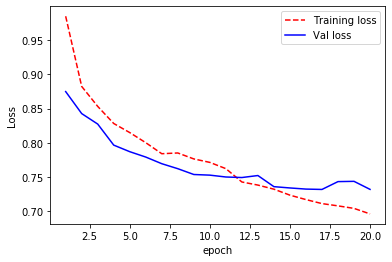

In [136]:
import matplotlib.pyplot as plt
#plotting the loss
epoch_count = range(1,len(training_loss) +1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss,'b-')
plt.legend(['Training loss', 'Val loss'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show();

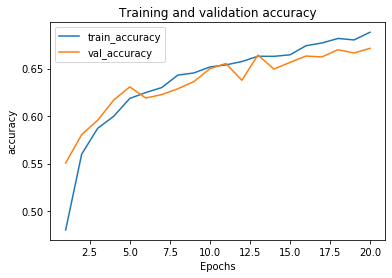

In [137]:
#plotting the accuracy
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history_s, 'accuracy')

In [139]:
#presdictions for the 15 observations to compare aginst the other models, Vader, and my own sentiment
tokenizer.fit_on_texts(sent_vader.content)
tokens_sequence = tokenizer.texts_to_sequences(sent_vader.content)
tokens_padding = pad_sequences(tokens_sequence, maxlen=MAX_LENGTH)
y_predict_new = (model_st.predict(tokens_padding)>0.5).astype('int32')
#y_predict =(y_pred>0.5)
y_predict_new=np.argmax(y_predict_new,1)
label_encoder.inverse_transform(y_predict_new)
#y_new=model_s.predict_classes(tokens_padding)

array(['pos', 'pos', 'neg', 'neg', 'neu', 'pos', 'neg', 'neg', 'pos',
       'neg', 'neu', 'neu', 'neu', 'neg', 'neu'], dtype=object)

In [140]:
#adding to the dataframe
list_nn_2=['pos', 'pos', 'neg', 'neg', 'neu', 'pos', 'neg', 'neg', 'pos',
       'neg', 'neu', 'neu', 'neu', 'neg', 'neu']
nn_se = pd.Series(list_nn_2)
sent_vader['LSTM_sent']=nn_se.values


In [145]:
sent_vader

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,compound,compound_txt,logistic_sent,randomforest_sent,LSTM_sent,xgb_sent
0,gp:AOqpTOEVAaqxNXyjz1hB3k7bEho_AxkJ7SrFwRwyyis...,I liike it,pos,0,25.9,2021/03/16,NaN,NaN,0.0000,neu,neu,pos,pos,pos
1,gp:AOqpTOFFp_buXI33ICX36w-olVNV5lFmecsHLkRzonr...,Good,pos,0,26.2.2,2021/03/16,NaN,NaN,0.4404,pos,pos,pos,pos,pos
2,gp:AOqpTOF8LXTtGD_LP6mw6LtOa3_sPBZA_9X5bDBpON2...,Wonder selection of music from all around the ...,pos,0,26.2.2,2021/03/16,NaN,NaN,0.6249,pos,pos,pos,neg,pos
3,gp:AOqpTOFsr7yM-5jNNc-SfkPgyA1SN-ErGk41mCpH3mD...,"I'm using TuneIn Radio since 2011 until now,th...",pos,0,26.2.2,2021/03/16,NaN,NaN,0.0000,neu,pos,neg,neg,neg
4,gp:AOqpTOH3n9ClNv33CGS_H2b9TEzNRkUKLI3EHsV6Z00...,App is Good but Reason Why is The Amazon App h...,neg,0,NaN,2021/03/16,NaN,NaN,0.4588,pos,neu,neu,neu,neu
5,gp:AOqpTOEUe27aJj8sNGxHIJZ3x_IxvQvW9qbsGH-4QuM...,Good,pos,0,26.2.2,2021/03/16,NaN,NaN,0.4404,pos,pos,pos,pos,pos
6,gp:AOqpTOHCknZY3z0h1LzbqNOJUw09folVEE9Uncaiu-d...,Does not work with some of my favorite stations,neg,0,NaN,2021/03/16,NaN,NaN,0.4588,pos,neu,neg,neg,neu
7,gp:AOqpTOETATayONoers4A5s6hKIfAYlPlC7ymz-twNPR...,"DO NOT INSTALL, Sold my info, I get daily call...",neg,0,25.9,2021/03/15,Thanks for writing to us. We do not sell users...,2021/03/15,0.2023,pos,neg,neg,neg,neg
8,gp:AOqpTOGey7pRRVoMnpemXVbJ0GpZ1v1DraKtyEt-dTB...,Trying,neg,0,NaN,2021/03/15,Thanks for writing to us. If you need assistan...,2021/03/15,0.0000,neu,pos,pos,pos,pos
9,gp:AOqpTOH5vKNQ-AQiZ0v8Ta-xVap_bjlT3VIio3DMRkR...,Nice lots of options. Buffers a lot regardless...,neu,0,26.2.2,2021/03/15,Thank you for writing to us. That shouldn't be...,2021/03/15,0.7269,pos,neu,neu,neg,neu


In [226]:
#creating a CNN 
model2.add(Embedding(len(word_index) + 1,
 100,
 weights=[embedding_matrix],
 input_length=MAX_LENGTH,
 trainable=False))
model2.add(Conv1D(512, 5,activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.55))
model2.add(Flatten())
model_st.add(Dense(256,activation='relu', kernel_regularizer=regularizers.l2(0.001))) 
model2.add(Dropout(0.5))
model_st.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001))) 
model2.add(Dropout(0.2))
model2.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001))) 
model2.add(Dense(3)) 
model2.add(Activation('softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [227]:
history = model2.fit(xtrain_padding, y=ytrain_encode, batch_size=500, epochs=17, verbose=1, validation_data=(xval_padding, yval_encode))


Epoch 1/17
30/30 [==============================] - 12s 395ms/step - loss: 1.2985 - accuracy: 0.4512 - val_loss: 1.1251 - val_accuracy: 0.5340
Epoch 2/17
30/30 [==============================] - 11s 380ms/step - loss: 1.0967 - accuracy: 0.5350 - val_loss: 1.0291 - val_accuracy: 0.5786
Epoch 3/17
30/30 [==============================] - 12s 387ms/step - loss: 1.0281 - accuracy: 0.5732 - val_loss: 0.9898 - val_accuracy: 0.6012
Epoch 4/17
30/30 [==============================] - 12s 383ms/step - loss: 0.9834 - accuracy: 0.5948 - val_loss: 0.9575 - val_accuracy: 0.6061
Epoch 5/17
30/30 [==============================] - 11s 377ms/step - loss: 0.9551 - accuracy: 0.6119 - val_loss: 0.9451 - val_accuracy: 0.6078
Epoch 6/17
30/30 [==============================] - 12s 389ms/step - loss: 0.9229 - accuracy: 0.6233 - val_loss: 0.9063 - val_accuracy: 0.6328
Epoch 7/17
30/30 [==============================] - 11s 383ms/step - loss: 0.8943 - accuracy: 0.6352 - val_loss: 0.8839 - val_accuracy: 0.6464

In [228]:
#testing on the testing set to check for any drastic differences with the validation data
test_loss, test_acc = model2.evaluate(xtest_padding, ytest_encode)
print('Test accuracy:', test_acc)

235/235 [==============================] - 2s 9ms/step - loss: 0.7789 - accuracy: 0.6705
Test accuracy: 0.6704924702644348


In [229]:
y_pred=model2.predict(xtest_padding)
y_pred =(y_pred>0.5)

In [230]:
#classification report
print(classification_report(ytest_encode, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.56      0.64      2500
           1       0.58      0.51      0.55      2443
           2       0.81      0.74      0.77      2550

   micro avg       0.71      0.61      0.65      7493
   macro avg       0.71      0.60      0.65      7493
weighted avg       0.71      0.61      0.65      7493
 samples avg       0.61      0.61      0.61      7493



In [231]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

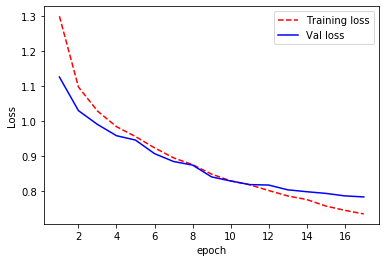

In [232]:
import matplotlib.pyplot as plt
#plotting the loss
epoch_count = range(1,len(training_loss) +1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss,'b-')
plt.legend(['Training loss', 'Val loss'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show();

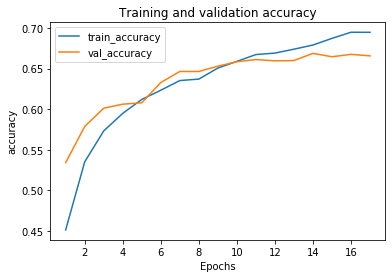

In [233]:
#plotting the accuracy
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history, 'accuracy')

In [234]:
#predictions for the 15 observations to compare against other models, Vader, and my own sentiment
tokenizer.fit_on_texts(sent_vader.content)
tokens_sequence = tokenizer.texts_to_sequences(sent_vader.content)
tokens_padding = pad_sequences(tokens_sequence, maxlen=MAX_LENGTH)
y_predict_new_2 = (model2.predict(tokens_padding)>0.5).astype('int32')
#y_predict =(y_pred>0.5)
y_predict_new_2=np.argmax(y_predict_new_2,1)
label_encoder.inverse_transform(y_predict_new_2)

array(['neg', 'pos', 'neu', 'pos', 'neu', 'pos', 'neg', 'neg', 'neg',
       'neu', 'neg', 'neg', 'neu', 'neg', 'neu'], dtype=object)

In [237]:
#adding the results to the dataframe
conv_list=['neg', 'pos', 'neu', 'pos', 'neu', 'pos', 'neg', 'neg', 'neg',
       'neu', 'neg', 'neg', 'neu', 'neg', 'neu']
nn_se_conv = pd.Series(conv_list)
sent_vader['conv_sent']=nn_se_conv.values

In [238]:
sent_vader

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,compound,compound_txt,logistic_sent,randomforest_sent,LSTM_sent,xgb_sent,conv_sent
0,gp:AOqpTOEVAaqxNXyjz1hB3k7bEho_AxkJ7SrFwRwyyis...,I liike it,pos,0,25.9,2021/03/16,NaN,NaN,0.0000,neu,neu,pos,pos,pos,neg
1,gp:AOqpTOFFp_buXI33ICX36w-olVNV5lFmecsHLkRzonr...,Good,pos,0,26.2.2,2021/03/16,NaN,NaN,0.4404,pos,pos,pos,pos,pos,pos
2,gp:AOqpTOF8LXTtGD_LP6mw6LtOa3_sPBZA_9X5bDBpON2...,Wonder selection of music from all around the ...,pos,0,26.2.2,2021/03/16,NaN,NaN,0.6249,pos,pos,pos,neg,pos,neu
3,gp:AOqpTOFsr7yM-5jNNc-SfkPgyA1SN-ErGk41mCpH3mD...,"I'm using TuneIn Radio since 2011 until now,th...",pos,0,26.2.2,2021/03/16,NaN,NaN,0.0000,neu,pos,neg,neg,neg,pos
4,gp:AOqpTOH3n9ClNv33CGS_H2b9TEzNRkUKLI3EHsV6Z00...,App is Good but Reason Why is The Amazon App h...,neg,0,NaN,2021/03/16,NaN,NaN,0.4588,pos,neu,neu,neu,neu,neu
5,gp:AOqpTOEUe27aJj8sNGxHIJZ3x_IxvQvW9qbsGH-4QuM...,Good,pos,0,26.2.2,2021/03/16,NaN,NaN,0.4404,pos,pos,pos,pos,pos,pos
6,gp:AOqpTOHCknZY3z0h1LzbqNOJUw09folVEE9Uncaiu-d...,Does not work with some of my favorite stations,neg,0,NaN,2021/03/16,NaN,NaN,0.4588,pos,neu,neg,neg,neu,neg
7,gp:AOqpTOETATayONoers4A5s6hKIfAYlPlC7ymz-twNPR...,"DO NOT INSTALL, Sold my info, I get daily call...",neg,0,25.9,2021/03/15,Thanks for writing to us. We do not sell users...,2021/03/15,0.2023,pos,neg,neg,neg,neg,neg
8,gp:AOqpTOGey7pRRVoMnpemXVbJ0GpZ1v1DraKtyEt-dTB...,Trying,neg,0,NaN,2021/03/15,Thanks for writing to us. If you need assistan...,2021/03/15,0.0000,neu,pos,pos,pos,pos,neg
9,gp:AOqpTOH5vKNQ-AQiZ0v8Ta-xVap_bjlT3VIio3DMRkR...,Nice lots of options. Buffers a lot regardless...,neu,0,26.2.2,2021/03/15,Thank you for writing to us. That shouldn't be...,2021/03/15,0.7269,pos,neu,neu,neg,neu,neu


In [314]:
#creating a separate dataframe with the predictions for the 15 set-aside text examples
#created to compare the performance of the models, Vader, and my own sentiment
pd.set_option('display.max_colwidth', None)
sent_vader_short=sent_vader[['content','score','compound_txt','logistic_sent', 'randomforest_sent', 'LSTM_sent', 'xgb_sent',
       'conv_sent', 'svm_sent']]
my_list=['pos','pos','pos','pos','neg','pos','neg','neg','neu','neu','neg','neg','neu','neg','neu']
human = pd.Series(my_list)
sent_vader_short['human_sent']=human.values
sent_vader_short

,content,score,compound_txt,logistic_sent,randomforest_sent,LSTM_sent,xgb_sent,conv_sent,svm_sent,human_sent
0,I liike it,pos,neu,neu,pos,pos,pos,neg,neu,pos
1,Good,pos,pos,pos,pos,pos,pos,pos,pos,pos
2,Wonder selection of music from all around the world. The options of smooth jazz are awesome,pos,pos,pos,pos,neg,pos,neu,pos,pos
3,"I'm using TuneIn Radio since 2011 until now,this is my official internet Radio application on my phone.",pos,neu,pos,neg,neg,neg,pos,neg,pos
4,App is Good but Reason Why is The Amazon App have a quick Download and I Got Kick When I Quit the app.. So I give them 1 star for now,neg,pos,neu,neu,neu,neu,neu,neu,neg
5,Good,pos,pos,pos,pos,pos,pos,pos,pos,pos
6,Does not work with some of my favorite stations,neg,pos,neu,neg,neg,neu,neg,neu,neg
7,"DO NOT INSTALL, Sold my info, I get daily calls a text from strange company's after installing. You can not turn it off. They are always watching and listening, have to go deep into settings just to exit app. May have to get new phone and change number just to be sure.",neg,pos,neg,neg,neg,neg,neg,neg,neg
8,Trying,neg,neu,pos,pos,pos,pos,neg,pos,neu
9,Nice lots of options. Buffers a lot regardless of on Wifi or data plan. Shuts down often and needs to be restarted. Based on this I will stick with the free version.,neu,pos,neu,neu,neg,neu,neu,neu,neu


In [3]:
#calculating the % of correctly identified sentiment 
import pandas as pd
percentage_correct=[]
data = [['Vader', 33], ['logistic regression', 67], ['random forest', 67], ['LSTM', 53],['xgboost',60],['convnet',60],['svm',80],['human',80]]
percentage = pd.DataFrame(data, columns = ['algorithm', 'percentage_correct'])
percentage.sort_values(by=['percentage_correct'],ascending=False).reset_index().drop(columns=['index'])

,algorithm,percentage_correct
0,svm,80
1,human,80
2,logistic regression,67
3,random forest,67
4,xgboost,60
5,convnet,60
6,LSTM,53
7,Vader,33
